# Not Using Pauli Frame Update

In [2]:
from qiskit import __version__
print(__version__)

2.1.1


In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, Pauli
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.controlflow import IfElseOp
from qiskit.circuit.library import XGate, ZGate
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
import importlib
import steane_ec_decoder2
importlib.reload(steane_ec_decoder2)
from steane_ec_decoder2 import lookup, hadamard_lookup, cz_lookup

In [5]:
# Custom Hadamard 
h_sub = QuantumCircuit(1, name='H_custom')
h_sub.h(0)
H_custom = h_sub.to_gate()

# Custom CNOT 
cx_sub = QuantumCircuit(2, name='CX_custom')
cx_sub.cx(0, 1)
CX_custom = cx_sub.to_gate()

# Custom CZ
cz_sub = QuantumCircuit(2, name='CZ_custom')
cz_sub.cz(0, 1)
CZ_custom = cz_sub.to_gate()

In [6]:
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

# Function for Encoding

In [7]:
def encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit)
    for i in range(7):
        qc.id(first_qubit+i)
    for i in range(4, 7):
        qc.h(first_qubit+i)
    qc.cx(first_qubit, first_qubit+1)
    qc.cx(first_qubit, first_qubit+2)
    qc.cx(first_qubit+6, first_qubit)
    qc.cx(first_qubit+6, first_qubit+1)
    qc.cx(first_qubit+5, first_qubit)
    qc.cx(first_qubit+6, first_qubit+3)
    qc.cx(first_qubit+5, first_qubit+2)
    qc.cx(first_qubit+4, first_qubit+1)
    qc.cx(first_qubit+5, first_qubit+3)
    qc.cx(first_qubit+4, first_qubit+2)
    qc.cx(first_qubit+4, first_qubit+3)

In [8]:
def perfect_encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit)
    for i in range(4, 7):
        qc.append(H_custom, [first_qubit+i])
    qc.append(CX_custom, [first_qubit, first_qubit+1])
    qc.append(CX_custom, [first_qubit, first_qubit+2])
    qc.append(CX_custom, [first_qubit+6, first_qubit])
    qc.append(CX_custom, [first_qubit+6, first_qubit+1])
    qc.append(CX_custom, [first_qubit+5, first_qubit])
    qc.append(CX_custom, [first_qubit+6, first_qubit+3])
    qc.append(CX_custom, [first_qubit+5, first_qubit+2])
    qc.append(CX_custom, [first_qubit+4, first_qubit+1])
    qc.append(CX_custom, [first_qubit+5, first_qubit+3])
    qc.append(CX_custom, [first_qubit+4, first_qubit+2])
    qc.append(CX_custom, [first_qubit+4, first_qubit+3])

# Functions for Logical |0> and Logical |+>

In [9]:
def logical_zero(qc: QuantumCircuit, first_qubit: int):
    for i in [0, 1, 3]:
        qc.append(H_custom, [first_qubit+i])
    
    qc.append(CX_custom, [first_qubit, first_qubit+4])
    qc.append(CX_custom, [first_qubit+1, first_qubit+2])
    qc.append(CX_custom, [first_qubit+3, first_qubit+5])
    qc.append(CX_custom, [first_qubit, first_qubit+6])
    qc.append(CX_custom, [first_qubit+3, first_qubit+4])
    qc.append(CX_custom, [first_qubit+1, first_qubit+5])
    qc.append(CX_custom, [first_qubit, first_qubit+2])
    qc.append(CX_custom, [first_qubit+5, first_qubit+6])

In [10]:
def logical_plus(qc: QuantumCircuit, first_qubit: int):
    logical_zero(qc, first_qubit)
    for i in range(7):
        qc.append(H_custom, [first_qubit+i])

# Functions for Stabilizer Extraction 

In [11]:
def flag(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister, c2: ClassicalRegister):
    qc.h(first_qubit+7)
    
    qc.cx(first_qubit+7, first_qubit+4)
    qc.cx(first_qubit+6, first_qubit+8)
    qc.cx(first_qubit+5, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit)
    qc.cx(first_qubit+4, first_qubit+8)
    qc.cx(first_qubit+1, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+2)
    qc.cx(first_qubit+3, first_qubit+8)
    qc.cx(first_qubit+6, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+6)
    qc.cx(first_qubit+5, first_qubit+8)
    qc.cx(first_qubit+2, first_qubit+9)
    
    qc.h(first_qubit+7)
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9], c1)
    qc.reset([first_qubit+7, first_qubit+8, first_qubit+9])
    
    qc.h(first_qubit+8)
    qc.h(first_qubit+9)
    
    qc.cx(first_qubit+4, first_qubit+7)
    qc.cx(first_qubit+8, first_qubit+6)
    qc.cx(first_qubit+9, first_qubit+5)
    qc.cx(first_qubit+9, first_qubit+7)
    qc.cx(first_qubit, first_qubit+7)
    qc.cx(first_qubit+8, first_qubit+4)
    qc.cx(first_qubit+9, first_qubit+1)
    qc.cx(first_qubit+2, first_qubit+7)
    qc.cx(first_qubit+8, first_qubit+3)
    qc.cx(first_qubit+9, first_qubit+6)
    qc.cx(first_qubit+8, first_qubit+7)
    qc.cx(first_qubit+6, first_qubit+7)
    qc.cx(first_qubit+8, first_qubit+5)
    qc.cx(first_qubit+9, first_qubit+2)
    
    qc.h(first_qubit+8)
    qc.h(first_qubit+9)
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9], c2)

# Function for QEC

In [12]:
def QEC(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister, c2: ClassicalRegister):
    flag(qc, first_qubit, c1, c2)

# Encoding + 1 Round of EC

In [15]:
ideal = QuantumCircuit(7)
perfect_encoding(ideal, 0)
ideal = DensityMatrix(ideal)


err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []
for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [7]) 
    noise_model.add_readout_error(readout_err, [8])
    noise_model.add_readout_error(readout_err, [9])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(10)

    c1 = ClassicalRegister(3, "c1")
    c2 = ClassicalRegister(3, "c2")

    qc.add_register(c1, c2)

    encoding(qc, 0)
    QEC(qc, 0, c1, c2)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=100_000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv10 = next(iter(result.items()))
        correction_x, correction_z = lookup(memory[i])
        if (correction_x is None or correction_z is None):
            continue
        correction_z = "I"*3 + correction_z[::-1]
        correction_x = "I"*3 + correction_x[::-1]
        Pauli_cz = Pauli(correction_z)
        Pauli_cx = Pauli(correction_x)
        sv10 = sv10.evolve(Pauli_cz)
        sv10 = sv10.evolve(Pauli_cx)
        sv_correction.append(sv10)
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [7, 8, 9])
        if (sv == ideal):
        #if (np.round(state_fidelity(sv, ideal)) == 1.0):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(1 - (sum / len(sv_correction)))

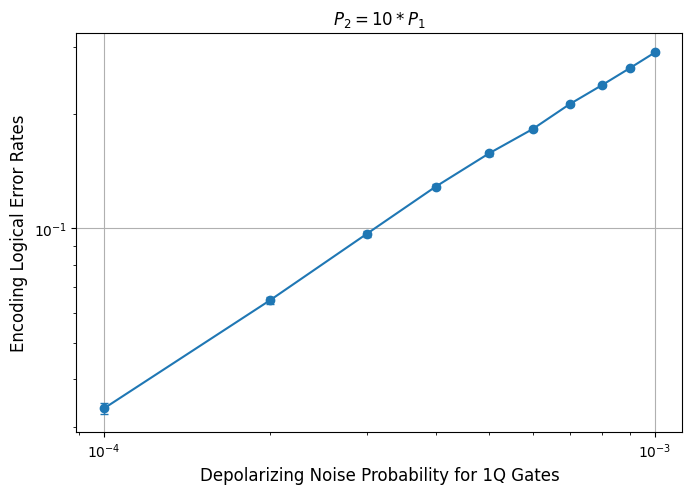

In [16]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Logical Error Rate for Hadamard

In [17]:
err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [0]) 
    noise_model.add_readout_error(readout_err, [1])
    noise_model.add_readout_error(readout_err, [2])
    noise_model.add_readout_error(readout_err, [3])
    noise_model.add_readout_error(readout_err, [4])
    noise_model.add_readout_error(readout_err, [5])
    noise_model.add_readout_error(readout_err, [6])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(7)

    c = ClassicalRegister(7, "c")

    qc.add_register(c)

    logical_plus(qc, 0)
    for i in range(7):
        qc.h(i)
    qc.measure([0, 1, 2, 3, 4, 5, 6], c)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=1_000_000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Count the correct outputs
    sum = 0
    for mem in memory:
        if (hadamard_lookup(mem) == 0):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(memory)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(1 - (sum / len(memory)))

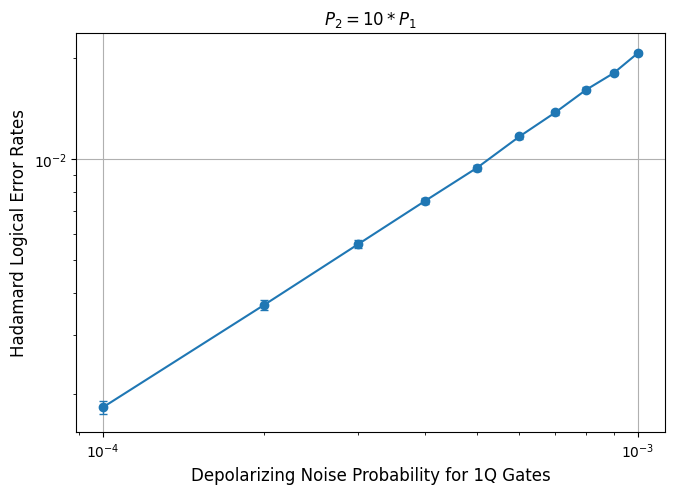

In [18]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Hadamard Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Logical Error Rate for CZ

In [19]:
err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    
    noise_model = NoiseModel()
    
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cz'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [0]) 
    noise_model.add_readout_error(readout_err, [1])
    noise_model.add_readout_error(readout_err, [2])
    noise_model.add_readout_error(readout_err, [3])
    noise_model.add_readout_error(readout_err, [4])
    noise_model.add_readout_error(readout_err, [5])
    noise_model.add_readout_error(readout_err, [6])
    
    noise_model.add_readout_error(readout_err, [7]) 
    noise_model.add_readout_error(readout_err, [8])
    noise_model.add_readout_error(readout_err, [9])
    noise_model.add_readout_error(readout_err, [10])
    noise_model.add_readout_error(readout_err, [11])
    noise_model.add_readout_error(readout_err, [12])
    noise_model.add_readout_error(readout_err, [13])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(14)

    c1 = ClassicalRegister(7, "c1")
    c2 = ClassicalRegister(7, "c2")

    qc.add_register(c1, c2)

    logical_plus(qc, 0)
    logical_plus(qc, 7)
    for i in range(7):
        qc.cz(i, i+7)
        qc.h(i+7)
    
    qc.measure([0, 1, 2, 3, 4, 5, 6], c1)
    qc.measure([7, 8, 9, 10, 11, 12, 13], c2)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=100000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Count the correct outputs
    sum = 0
    for mem in memory:
        if (cz_lookup(mem)):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(memory)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(1 - (sum / len(memory)))

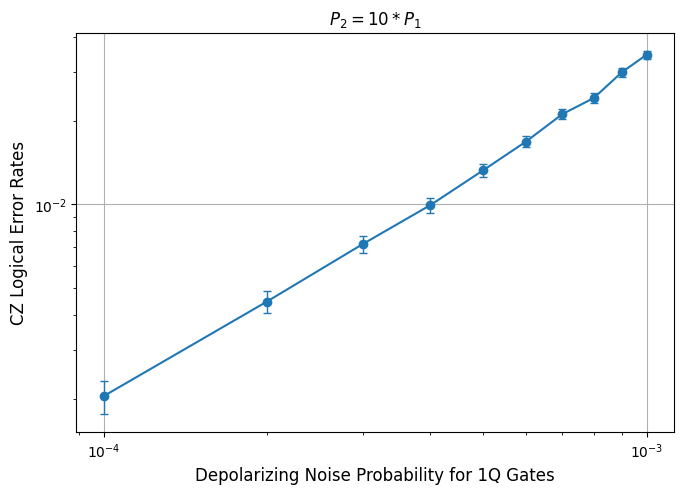

In [20]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("CZ Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()